In [1]:
import os
import sys

sys.path.insert(0, "../../")

import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', None)
import pathlib
from lips.augmented_simulators.tensorflow_models.powergrid import TfResNetPowerGrid

from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from lips.dataset.scaler import  StandardScaler

from lips.config import ConfigManager
from lips.utils import get_path

In [2]:
# indicate required paths
LIPS_PATH = pathlib.Path().resolve().parent.parent # it is supposed that the notebook had run from getting_started folder
DATA_PATH = LIPS_PATH / "reference_data" / "powergrid" / "l2rpn_case14_sandbox"
BENCH_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "benchmarks" / "l2rpn_case14_sandbox.ini"
SIM_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "simulators"
BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
TRAINED_BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
EVALUATION_PATH = LIPS_PATH / "evaluation_results" / "PowerGrid"
LOG_PATH = LIPS_PATH / "lips_logs.log"

# 1. l2rpn_case14_sandbox grid

## 1.1 Benchmark2

In [3]:
benchmark2 = PowerGridBenchmark(benchmark_name="Benchmark2",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH
                               )

In [4]:
bench_config = ConfigManager(section_name="Benchmark2", path=BENCH_CONFIG_PATH)
topo_actions = bench_config.get_option("dataset_create_params")["train"]["topo_actions"]

kwargs_tau = []
for el in topo_actions:
     kwargs_tau.append(el["set_bus"]["substations_id"][0])
                       
kwargs_tau

[(5, (1, 1, 2, 2, 1, 2, 2)),
 (4, (2, 1, 2, 1, 2)),
 (3, (2, 1, 1, 2, 1, 2)),
 (8, (2, 1, 1, 2, 2)),
 (1, (1, 2, 1, 2, 2, 2))]

### Tensorflow ResNet 

In [5]:
tf_resnet = TfResNetPowerGrid(name="tf_resnet",
                         bench_config_path=BENCH_CONFIG_PATH,
                         bench_config_name="Benchmark2",
                         topo_vect_to_tau="given_list",
                         kwargs_tau=kwargs_tau,
                         layers = [200, 200, 200],
                         scale_input_layer = True,

                         lr = 1e-4,
                                      
                         loss = {"name": "mse"},
                         layer = "resnet",
                         activation = "elu",
                         sim_config_path=SIM_CONFIG_PATH / "tf_fc.ini",
                         sim_config_name="DEFAULT",
                         log_path=LOG_PATH,
                         scaler = StandardScaler,
                                     
                                     )

In [6]:
import time
start_time = time.time()

In [7]:
tf_resnet.train(train_dataset=benchmark2.train_dataset,
            val_dataset=benchmark2.val_dataset,
            batch_size = 128,
            epochs= 400)

2022-07-22 14:03:41.258240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-22 14:03:41.720395: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5120 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:03:00.0, compute capability: 8.6


Epoch 1/400
  44/1172 [>.............................] - ETA: 3s - loss: 0.9403 - mae: 0.6409 

2022-07-22 14:03:43.723011: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1172/1172 [==============================] - 6s 4ms/step - loss: 0.1042 - mae: 0.1727 - val_loss: 0.0254 - val_mae: 0.1017
Epoch 2/400
1172/1172 [==============================] - 5s 4ms/step - loss: 0.0145 - mae: 0.0778 - val_loss: 0.0113 - val_mae: 0.0696
Epoch 3/400
1172/1172 [==============================] - 5s 4ms/step - loss: 0.0079 - mae: 0.0581 - val_loss: 0.0071 - val_mae: 0.0558
Epoch 4/400
1172/1172 [==============================] - 5s 4ms/step - loss: 0.0055 - mae: 0.0488 - val_loss: 0.0053 - val_mae: 0.0487
Epoch 5/400
1172/1172 [==============================] - 5s 4ms/step - loss: 0.0042 - mae: 0.0427 - val_loss: 0.0041 - val_mae: 0.0427
Epoch 6/400
1172/1172 [==============================] - 5s 4ms/step - loss: 0.0034 - mae: 0.0387 - val_loss: 0.0035 - val_mae: 0.0391
Epoch 7/400
1172/1172 [==============================] - 5s 4ms/step - loss: 0.0029 - mae: 0.0355 - val_loss: 0.0030 - val_mae: 0.0367
Epoch 8/400
1172/1172 [==============================] - 5s 4ms/ste

Epoch 116/400
1172/1172 [==============================] - 5s 4ms/step - loss: 2.5944e-04 - mae: 0.0102 - val_loss: 2.3634e-04 - val_mae: 0.0102
Epoch 117/400
1172/1172 [==============================] - 5s 4ms/step - loss: 2.3656e-04 - mae: 0.0099 - val_loss: 2.2574e-04 - val_mae: 0.0097
Epoch 118/400
1172/1172 [==============================] - 5s 4ms/step - loss: 3.2062e-04 - mae: 0.0106 - val_loss: 1.7852e-04 - val_mae: 0.0089
Epoch 119/400
1172/1172 [==============================] - 5s 4ms/step - loss: 1.9699e-04 - mae: 0.0092 - val_loss: 2.2836e-04 - val_mae: 0.0098
Epoch 120/400
1172/1172 [==============================] - 5s 4ms/step - loss: 2.6006e-04 - mae: 0.0103 - val_loss: 3.6854e-04 - val_mae: 0.0117
Epoch 121/400
1172/1172 [==============================] - 5s 4ms/step - loss: 2.3572e-04 - mae: 0.0097 - val_loss: 1.9942e-04 - val_mae: 0.0094
Epoch 122/400
1172/1172 [==============================] - 5s 4ms/step - loss: 2.1764e-04 - mae: 0.0097 - val_loss: 2.8284e-04 - v

1172/1172 [==============================] - 5s 4ms/step - loss: 1.3704e-04 - mae: 0.0075 - val_loss: 1.8516e-04 - val_mae: 0.0090
Epoch 229/400
1172/1172 [==============================] - 5s 4ms/step - loss: 1.3365e-04 - mae: 0.0073 - val_loss: 3.2700e-04 - val_mae: 0.0112
Epoch 230/400
1172/1172 [==============================] - 5s 4ms/step - loss: 1.4534e-04 - mae: 0.0077 - val_loss: 1.7561e-04 - val_mae: 0.0068
Epoch 231/400
1172/1172 [==============================] - 5s 4ms/step - loss: 1.4038e-04 - mae: 0.0075 - val_loss: 1.3501e-04 - val_mae: 0.0076
Epoch 232/400
1172/1172 [==============================] - 5s 4ms/step - loss: 1.3070e-04 - mae: 0.0073 - val_loss: 1.7704e-04 - val_mae: 0.0081
Epoch 233/400
1172/1172 [==============================] - 5s 4ms/step - loss: 1.4564e-04 - mae: 0.0077 - val_loss: 1.1839e-04 - val_mae: 0.0069
Epoch 234/400
1172/1172 [==============================] - 5s 4ms/step - loss: 1.4151e-04 - mae: 0.0075 - val_loss: 6.0904e-04 - val_mae: 0.0117

1172/1172 [==============================] - 5s 4ms/step - loss: 1.0792e-04 - mae: 0.0066 - val_loss: 9.8379e-05 - val_mae: 0.0063
Epoch 341/400
1172/1172 [==============================] - 5s 4ms/step - loss: 1.1187e-04 - mae: 0.0066 - val_loss: 1.2144e-04 - val_mae: 0.0068
Epoch 342/400
1172/1172 [==============================] - 5s 4ms/step - loss: 8.6414e-05 - mae: 0.0059 - val_loss: 1.0859e-04 - val_mae: 0.0065
Epoch 343/400
1172/1172 [==============================] - 5s 4ms/step - loss: 1.1575e-04 - mae: 0.0067 - val_loss: 8.9718e-05 - val_mae: 0.0059
Epoch 344/400
1172/1172 [==============================] - 5s 4ms/step - loss: 9.3038e-05 - mae: 0.0061 - val_loss: 1.2407e-04 - val_mae: 0.0072
Epoch 345/400
1172/1172 [==============================] - 5s 4ms/step - loss: 1.0201e-04 - mae: 0.0062 - val_loss: 1.3124e-04 - val_mae: 0.0073
Epoch 346/400
1172/1172 [==============================] - 5s 4ms/step - loss: 9.4928e-05 - mae: 0.0062 - val_loss: 9.6094e-05 - val_mae: 0.0062

In [8]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 2172.4908232688904 seconds ---


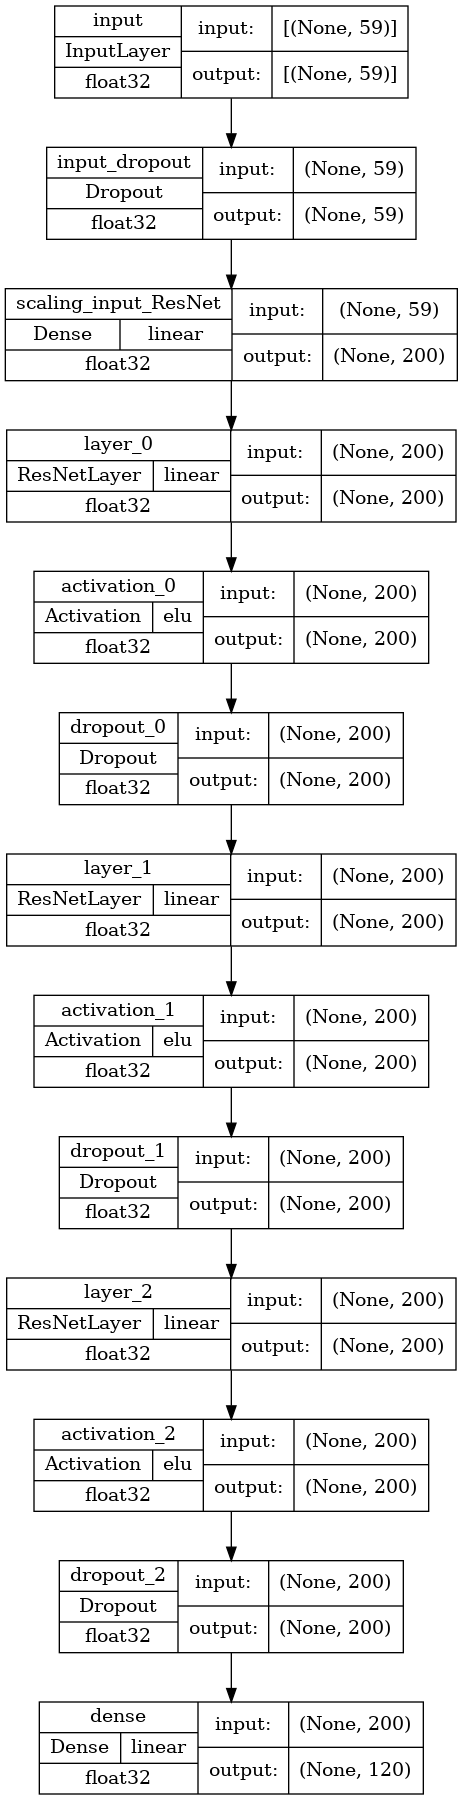

In [9]:
tf.keras.utils.plot_model(
    tf_resnet._model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations= True)

In [10]:
tf_resnet.summary()

Model: "tf_fc_DEFAULT_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 59)]              0         
                                                                 
 input_dropout (Dropout)     (None, 59)                0         
                                                                 
 scaling_input_ResNet (Dense  (None, 200)              12000     
 )                                                               
                                                                 
 layer_0 (ResNetLayer)       (None, 200)               80400     
                                                                 
 activation_0 (Activation)   (None, 200)               0         
                                                                 
 dropout_0 (Dropout)         (None, 200)               0         
                                               

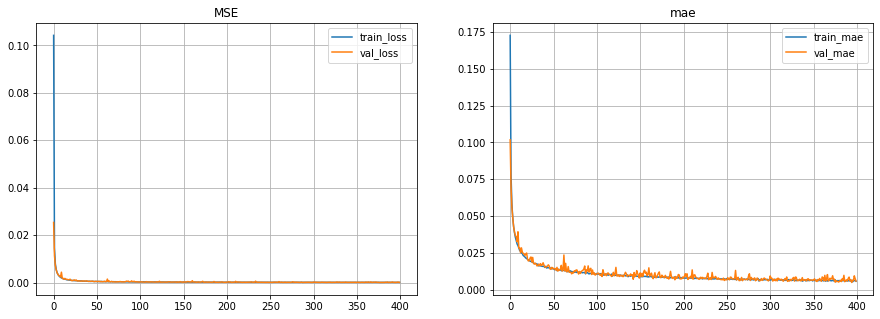

In [11]:
tf_resnet.visualize_convergence()

In [12]:
tf_fc_metrics2 = benchmark2.evaluate_simulator(augmented_simulator=tf_resnet,
                                              eval_batch_size=128,
                                              dataset="all",
                                              shuffle=False,
                                              save_predictions=True
                                             )

1/1 [==============================] - 0s 34ms/step


100%|██████████| 50000/50000 [04:35<00:00, 181.81it/s]


 33/391 [=>............................] - ETA: 0s

/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../lips/benchmark/powergridBenchmark.py:351: UserWarning: You indicate to save the predictions, without providing a path. No predictions will be saved!
  warnings.warn(message="You indicate to save the predictions, without providing a path. No predictions will be saved!")


1/1 [==============================] - 0s 22ms/step


100%|██████████| 50000/50000 [04:29<00:00, 185.36it/s]


167/167 [==============================] - 0s 1ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../lips/benchmark/powergridBenchmark.py:351: UserWarning: You indicate to save the predictions, without providing a path. No predictions will be saved!
  warnings.warn(message="You indicate to save the predictions, without providing a path. No predictions will be saved!")


1/1 [==============================] - 0s 66ms/step


100%|██████████| 150000/150000 [13:34<00:00, 184.15it/s]


500/500 [==============================] - 1s 2ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../lips/benchmark/powergridBenchmark.py:351: UserWarning: You indicate to save the predictions, without providing a path. No predictions will be saved!
  warnings.warn(message="You indicate to save the predictions, without providing a path. No predictions will be saved!")


In [13]:
SAVE_PATH = get_path(TRAINED_BASELINES_PATH, benchmark1)
tf_resnet.save(SAVE_PATH)

NameError: name 'benchmark1' is not defined

In [ ]:
import numpy as np
eval_metrics = tf_fc_metrics2

## A 

In [ ]:
a_test_list = [eval_metrics["test"]["ML"]["mape_90_avg"]["a_or"], eval_metrics["test"]["ML"]["mape_90_avg"]["a_ex"]]
a_ood_list = [eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"]["a_or"], eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"]["a_ex"]]

In [ ]:
print("ML : MAPE90 --> A : mean :{}, std :{}".format(np.mean(a_test_list), np.std(a_test_list)))
print("OOD : MAPE90 --> A : mean :{}, std :{}".format(np.mean(a_ood_list), np.std(a_ood_list)))

## P

In [ ]:
p_test_list = [eval_metrics["test"]["ML"]["mape_avg"]["p_or"], eval_metrics["test"]["ML"]["mape_avg"]["p_ex"]]
p_ood_list = [eval_metrics["test_ood_topo"]["ML"]["mape_avg"]["p_or"], eval_metrics["test_ood_topo"]["ML"]["mape_avg"]["p_ex"]]

In [ ]:
print("ML : MAPE --> P : mean :{}, std :{}".format(np.mean(p_test_list), np.std(p_test_list)))
print("OOD : MAPE --> P : mean :{}, std :{}".format(np.mean(p_ood_list), np.std(p_ood_list)))

## V 

In [ ]:
v_test_list = [eval_metrics["test"]["ML"]["MAE_avg"]["v_or"], eval_metrics["test"]["ML"]["MAE_avg"]["v_ex"]]
v_ood_list = [eval_metrics["test_ood_topo"]["ML"]["MAE_avg"]["v_or"], eval_metrics["test_ood_topo"]["ML"]["MAE_avg"]["v_ex"]]

In [ ]:
print("ML : MAE --> V : mean :{}, std :{}".format(np.mean(v_test_list), np.std(v_test_list)))
print("OOD : MAE --> V : mean :{}, std :{}".format(np.mean(v_ood_list), np.std(v_ood_list)))

## Inf speed-up

In [ ]:
print("ML : Inf speed-up :", eval_metrics["test"]["ML"]["TIME_INF"])

## Physics ML

In [ ]:
print("1) Current positivity violation:", (eval_metrics["test"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"]+eval_metrics["test"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"])/2)#["a_or"]["Violation_proportion"]
print("2) Voltage positivity violation:", (eval_metrics["test"]["Physics"]["VOLTAGE_POS"]["v_or"]["Violation_proportion"]+eval_metrics["test"]["Physics"]["VOLTAGE_POS"]["v_ex"]["Violation_proportion"])/2)
print("3) Loss positivity violation:", eval_metrics["test"]["Physics"]["LOSS_POS"]["violation_proportion"])
print("4) Disconnected lines violation:", eval_metrics["test"]["Physics"]["DISC_LINES"])
print("5) Violation of loss to be between [1,4]% of production:", eval_metrics["test"]["Physics"]["CHECK_LOSS"]["violation_percentage"])
print("6) Violation of global conservation: {}% and its weighted mape: {}".format(eval_metrics["test"]["Physics"]["CHECK_GC"]["violation_percentage"], eval_metrics["test"]["Physics"]["CHECK_GC"]["wmape"]))
print("7) Violation of local conservation: {}% and its weighted mape: {}".format(eval_metrics["test"]["Physics"]["CHECK_LC"]["violation_percentage"], eval_metrics["test"]["Physics"]["CHECK_LC"]["mape"]))
print("8) Violation proportion of voltage equality at subs:", eval_metrics["test"]["Physics"]["CHECK_VOLTAGE_EQ"]["prop_voltages_violation"])

## Physics OOD

In [ ]:
print("1) Current positivity violation:", (eval_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"]+eval_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"])/2)#["a_or"]["Violation_proportion"]
print("2) Voltage positivity violation:", (eval_metrics["test_ood_topo"]["Physics"]["VOLTAGE_POS"]["v_or"]["Violation_proportion"]+eval_metrics["test_ood_topo"]["Physics"]["VOLTAGE_POS"]["v_ex"]["Violation_proportion"])/2)
print("3) Loss positivity violation:", eval_metrics["test_ood_topo"]["Physics"]["LOSS_POS"]["violation_proportion"])
print("4) Disconnected lines violation:", eval_metrics["test_ood_topo"]["Physics"]["DISC_LINES"])
print("5) Violation of loss to be between [1,4]% of production:", eval_metrics["test_ood_topo"]["Physics"]["CHECK_LOSS"]["violation_percentage"])
print("6) Violation of global conservation: {}% and its weighted mape: {}".format(eval_metrics["test_ood_topo"]["Physics"]["CHECK_GC"]["violation_percentage"], eval_metrics["test_ood_topo"]["Physics"]["CHECK_GC"]["wmape"]))
print("7) Violation of local conservation: {}% and its weighted mape: {}".format(eval_metrics["test_ood_topo"]["Physics"]["CHECK_LC"]["violation_percentage"], eval_metrics["test_ood_topo"]["Physics"]["CHECK_LC"]["mape"]))
print("8) Violation proportion of voltage equality at subs:", eval_metrics["test_ood_topo"]["Physics"]["CHECK_VOLTAGE_EQ"]["prop_voltages_violation"])